In [23]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [27]:
features_num = [
     'redshift', 'u_prime', 'NOAO_Bw', 'NOAO_R', 'NOAO_I', 'z_prime',
       'SUBARU_z', 'subaru.hsc.y', 'NEWFIRM_J', 'NEWFIRM_H', 'WFI_K',
       'noao.Ks', 'IRAC1', 'IRAC2', 'IRAC3', 'IRAC4', 'MIPS1',
       'herschel.pacs.100', 'herschel.pacs.160', 'PSW', 'PMW', 'PLW'
]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [25]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/Bootes_preprocessed_cigale.csv")

In [26]:
data.columns

Index(['id', 'redshift', 'u_prime', 'NOAO_Bw', 'NOAO_R', 'NOAO_I', 'z_prime',
       'SUBARU_z', 'subaru.hsc.y', 'NEWFIRM_J', 'NEWFIRM_H', 'WFI_K',
       'noao.Ks', 'IRAC1', 'IRAC2', 'IRAC3', 'IRAC4', 'MIPS1',
       'herschel.pacs.100', 'herschel.pacs.160', 'PSW', 'PMW', 'PLW',
       'Source_Name', 'AGN_final', 'RadioAGN_final', 'Classification',
       'Radio_excess', 'AGNfrac_af', 'AGNfrac_af_16', 'AGNfrac_cg_s_16'],
      dtype='object')

In [29]:
data = data.dropna()

In [30]:
X = data[features_num]
y = data[y_column]

In [31]:
le = LabelEncoder()
labels = np.unique(y.astype(str))
y = le.fit_transform(y)

In [32]:
# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [33]:
def one_hot(df, columns):
    """
    One-hot encoding a certain column in a dataframe
    """
    one_hot = pd.get_dummies(df[columns])
    df = df.drop(columns=columns, axis = 1)
    df = df.join(one_hot)
    return df

In [34]:
# Imputing missing categorical features
imp = SimpleImputer(strategy="most_frequent")

# Standard scaling the numerical data
scaler = MinMaxScaler()

# Transforming the categorical data
X_train[features_num] = scaler.fit_transform(X_train[features_num])
X_test[features_num] = scaler.transform(X_test[features_num])

In [35]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Random forest

In [36]:
clf = RandomForestClassifier(n_estimators=50, 
                             max_features=None,
                             n_jobs=-1, 
                             class_weight="balanced", 
                             random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features=None,
                       n_estimators=50, n_jobs=-1, random_state=42)

In [195]:
cv_score = cross_val_score(clf, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [196]:
print("Cross-validated Accuracy:", round(np.mean(cv_score), 5), "±", round(np.std(cv_score), 5))

Cross-validated Accuracy: 0.83311 ± 0.01399


In [37]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8333    0.5519    0.6641       154
quasar-like radio AGN / high-excitation radio galaxy     0.6000    0.0833    0.1463        36
                                     radio-quiet AGN     0.7524    0.5940    0.6639       133
                                 star-forming galaxy     0.8724    0.9755    0.9211       939

                                            accuracy                         0.8582      1262
                                           macro avg     0.7645    0.5512    0.5988      1262
                                        weighted avg     0.8472    0.8582    0.8405      1262



[]

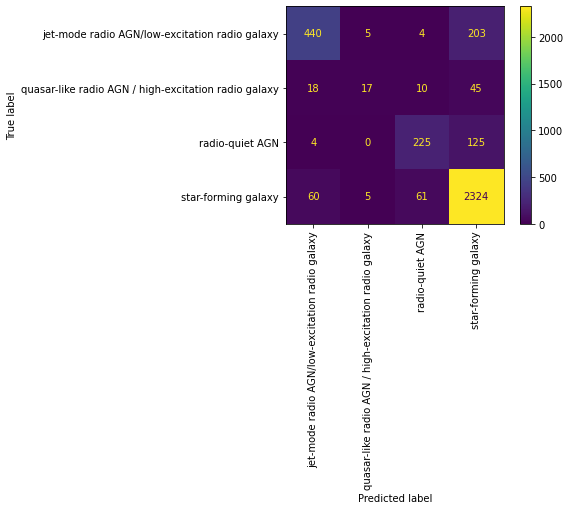

In [211]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# Lightgbm

In [229]:
import lightgbm as lgb
lightbm = lgb.LGBMClassifier(num_class=4, 
                             objective="multiclass",  
                             n_estimators=200, 
                             class_weight="balanced",
                             max_depth=7, 
                             num_leaves=32, 
                             min_child_samples=5,
                             reg_alpha=1,
                             reg_lambda=2)

In [230]:
lightbm.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', max_depth=8, min_child_samples=5,
               n_estimators=200, num_class=4, num_leaves=32,
               objective='multiclass', reg_alpha=1, reg_lambda=2)

In [231]:
cv_score_lgb = cross_val_score(lightbm, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [232]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_lgb), 5), "±", round(np.std(cv_score_lgb), 5))

Cross-validated Accuracy: 0.87436 ± 0.01571


In [233]:
y_pred = lightbm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8178    0.8604    0.8386       652
quasar-like radio AGN / high-excitation radio galaxy     0.5536    0.3444    0.4247        90
                                     radio-quiet AGN     0.6752    0.8220    0.7414       354
                                 star-forming galaxy     0.9410    0.9114    0.9260      2450

                                            accuracy                         0.8787      3546
                                           macro avg     0.7469    0.7346    0.7327      3546
                                        weighted avg     0.8820    0.8787    0.8788      3546



[]

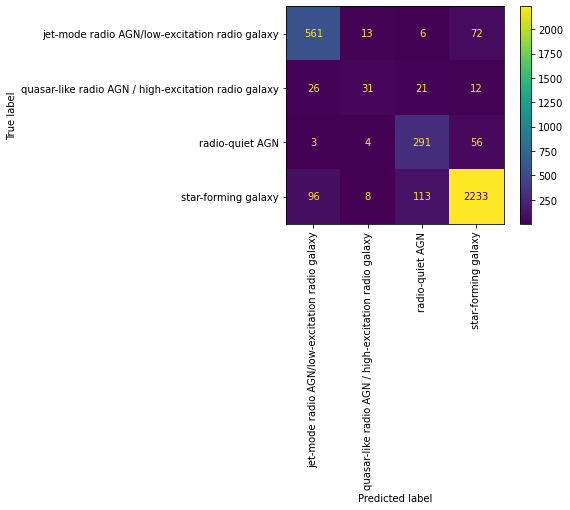

In [234]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# XGBoost

In [41]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=3, 
                      reg_alpha=0, 
                      min_child_weight=0.5, 
                      reg_lambda=1,
                      eta=0.05,
                      tree_method='exact',
                      eval_metric=['merror', 'auc'],
                      objective='multi:softprob',
                      n_estimators=10000, 
                      early_stopping_rounds=50)
bst = model.fit(X_train, y_train, 
                eval_set=[(X_test, y_test)], verbose=True, 
                sample_weight=classes_weights
               ) # Maybe remove weight

[0]	validation_0-merror:0.25277	validation_0-auc:0.86762
[1]	validation_0-merror:0.26862	validation_0-auc:0.87186
[2]	validation_0-merror:0.25515	validation_0-auc:0.87242
[3]	validation_0-merror:0.24960	validation_0-auc:0.87338
[4]	validation_0-merror:0.24723	validation_0-auc:0.87738
[5]	validation_0-merror:0.24960	validation_0-auc:0.87998
[6]	validation_0-merror:0.23851	validation_0-auc:0.88205
[7]	validation_0-merror:0.23851	validation_0-auc:0.88303
[8]	validation_0-merror:0.23851	validation_0-auc:0.88343
[9]	validation_0-merror:0.24010	validation_0-auc:0.88411
[10]	validation_0-merror:0.23613	validation_0-auc:0.88479
[11]	validation_0-merror:0.23376	validation_0-auc:0.88655
[12]	validation_0-merror:0.23376	validation_0-auc:0.88704
[13]	validation_0-merror:0.22662	validation_0-auc:0.88773
[14]	validation_0-merror:0.23138	validation_0-auc:0.88921
[15]	validation_0-merror:0.22900	validation_0-auc:0.88927
[16]	validation_0-merror:0.22742	validation_0-auc:0.89039
[17]	validation_0-merror

[141]	validation_0-merror:0.15848	validation_0-auc:0.91718
[142]	validation_0-merror:0.15769	validation_0-auc:0.91728
[143]	validation_0-merror:0.15769	validation_0-auc:0.91728
[144]	validation_0-merror:0.15769	validation_0-auc:0.91726
[145]	validation_0-merror:0.15769	validation_0-auc:0.91725
[146]	validation_0-merror:0.15689	validation_0-auc:0.91727
[147]	validation_0-merror:0.15689	validation_0-auc:0.91723
[148]	validation_0-merror:0.15531	validation_0-auc:0.91726
[149]	validation_0-merror:0.15610	validation_0-auc:0.91731
[150]	validation_0-merror:0.15610	validation_0-auc:0.91733
[151]	validation_0-merror:0.15689	validation_0-auc:0.91738
[152]	validation_0-merror:0.15769	validation_0-auc:0.91724
[153]	validation_0-merror:0.15769	validation_0-auc:0.91728
[154]	validation_0-merror:0.15689	validation_0-auc:0.91722
[155]	validation_0-merror:0.15610	validation_0-auc:0.91715
[156]	validation_0-merror:0.15610	validation_0-auc:0.91721
[157]	validation_0-merror:0.15531	validation_0-auc:0.917

In [225]:
cv_score_xgb = cross_val_score(model, X_train, y_train, cv=8, n_jobs=-1, scoring="accuracy")

In [123]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_xgb), 5), "±", round(np.std(cv_score_xgb), 5))

NameError: name 'cv_score_xgb' is not defined

In [42]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.6667    0.7143    0.6897       154
quasar-like radio AGN / high-excitation radio galaxy     0.4444    0.2222    0.2963        36
                                     radio-quiet AGN     0.6013    0.6917    0.6434       133
                                 star-forming galaxy     0.9222    0.9095    0.9158       939

                                            accuracy                         0.8431      1262
                                           macro avg     0.6587    0.6344    0.6363      1262
                                        weighted avg     0.8436    0.8431    0.8418      1262



[]

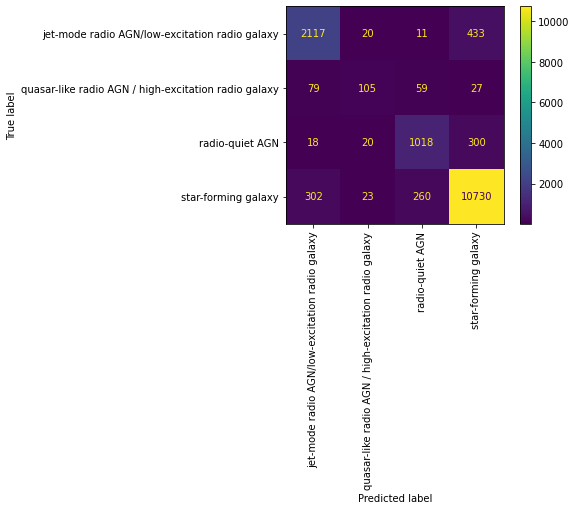

In [21]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

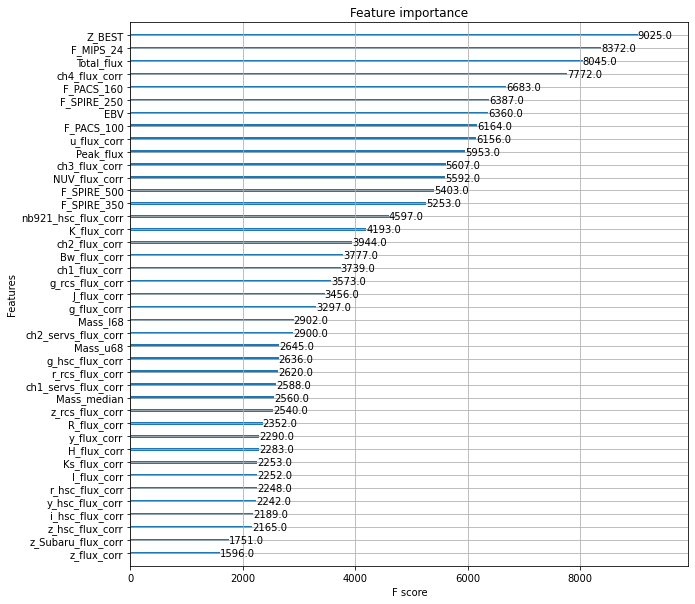

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)

## Hyperparameter fitting

In [11]:
import multiprocessing

multiprocessing.cpu_count()

192

In [13]:
# Metrics for hyperparameter tuning
metrics = {"Accuracy": "accuracy",
          "Balanced accuracy": "balanced_accuracy",
          "F1 score": "f1_weighted"}

In [14]:
# Parameter space
parameters = { 
         "max_depth": [8,9,10,11],
         "reg_alpha": [0,1,3,5], 
        "reg_lambda": [0,1,3,5],
        "gamma": [0,0.5,3],
        "eta": [0.1, 0.3],
        "min_child_weight": [0, 0.2, 0.5, 1]}

In [15]:
model = XGBClassifier(use_label_encoder=False,
                      tree_method='exact',
                      eval_metric='auc',
                      n_estimators=1000, 
                      early_stopping_rounds=30,)

In [16]:
clf = GridSearchCV(estimator=model, 
                   param_grid=parameters,
                  scoring=metrics,
                  refit="Accuracy",
                  return_train_score=True,
                  n_jobs=128,
                  cv=2,
                  verbose=1)

grid = clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

Fitting 2 folds for each of 1536 candidates, totalling 3072 fits


/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [17]:
clf.best_params_, clf.best_score_

({'eta': 0.1,
  'gamma': 0,
  'max_depth': 8,
  'min_child_weight': 0.5,
  'reg_alpha': 0,
  'reg_lambda': 1},
 0.8939391641429841)

In [ ]:
bui{'eta': 0.1,
  'gamma': 0,
  'max_depth': 8,
  'min_child_weight': 0.5,
  'reg_alpha': 0,
  'reg_lambda': 1},
 0.8939391641429841

In [20]:
model = XGBClassifier(use_label_encoder=False,
                      tree_method='exact',
                      eval_metric='auc',
                      n_estimators=400, 
                     **clf.best_params_)

In [21]:
cv_score_xgb = cross_val_score(model, X_train, y_train, cv=32,  n_jobs=32, scoring="accuracy")

In [22]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_xgb), 5), "±", round(np.std(cv_score_xgb), 5))

Cross-validated Accuracy: 0.89821 ± 0.00676


In [35]:
model = XGBClassifier(use_label_encoder=False,
                      tree_method='exact',
                      eval_metric='auc',
                      n_estimators=1000, 
                      early_stopping_rounds=30,
                     **clf.best_params_)

In [36]:
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# DNN

In [27]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dic = {i:class_weight[i] for i in range(4)}

In [28]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train.shape[1],)
        ),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(4),
    ]
)

2022-06-19 17:41:31.576830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-19 17:41:31.585914: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-19 17:41:31.585970: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterhub1.intra.astro.rug.nl): /proc/driver/nvidia/version does not exist
2022-06-19 17:41:31.592309: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="Adam",
    metrics=["accuracy"],
)

In [34]:
model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=1000,
    #callbacks=callbacks,
    validation_data=(X_test, y_test),
    #class_weight=class_weight_dic,
)

Epoch 1/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4616 - accuracy: 0.8264 - val_loss: 0.4683 - val_accuracy: 0.8280
Epoch 2/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.4607 - accuracy: 0.8268 - val_loss: 0.4731 - val_accuracy: 0.8235
Epoch 3/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.4582 - accuracy: 0.8268 - val_loss: 0.4658 - val_accuracy: 0.8298
Epoch 4/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4562 - accuracy: 0.8284 - val_loss: 0.4708 - val_accuracy: 0.8295
Epoch 5/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4564 - accuracy: 0.8285 - val_loss: 0.4737 - val_accuracy: 0.8252
Epoch 6/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4563 - accuracy: 0.8287 - val_loss: 0.4643 - val_accuracy: 0.8292
Epoch 7/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4524 - accuracy: 0.8292 - val_loss: 0.4653 - val_accuracy: 0.8304

Epoch 58/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4385 - accuracy: 0.8332 - val_loss: 0.4532 - val_accuracy: 0.8308
Epoch 59/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4398 - accuracy: 0.8328 - val_loss: 0.4571 - val_accuracy: 0.8300
Epoch 60/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.4386 - accuracy: 0.8330 - val_loss: 0.4610 - val_accuracy: 0.8302
Epoch 61/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4393 - accuracy: 0.8341 - val_loss: 0.4660 - val_accuracy: 0.8293
Epoch 62/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4347 - accuracy: 0.8351 - val_loss: 0.4576 - val_accuracy: 0.8315
Epoch 63/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4350 - accuracy: 0.8349 - val_loss: 0.4617 - val_accuracy: 0.8306
Epoch 64/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4370 - accuracy: 0.8340 - val_loss: 0.4598 - val_accuracy:

Epoch 115/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4234 - accuracy: 0.8381 - val_loss: 0.4549 - val_accuracy: 0.8353
Epoch 116/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4273 - accuracy: 0.8377 - val_loss: 0.4476 - val_accuracy: 0.8364
Epoch 117/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4231 - accuracy: 0.8385 - val_loss: 0.4514 - val_accuracy: 0.8333
Epoch 118/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4255 - accuracy: 0.8380 - val_loss: 0.4704 - val_accuracy: 0.8318
Epoch 119/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4251 - accuracy: 0.8375 - val_loss: 0.4598 - val_accuracy: 0.8327
Epoch 120/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4230 - accuracy: 0.8393 - val_loss: 0.4579 - val_accuracy: 0.8313
Epoch 121/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.4193 - accuracy: 0.8384 - val_loss: 0.4482 - val_ac

61/61 [==============================] - 1s 14ms/step - loss: 0.4075 - accuracy: 0.8439 - val_loss: 0.4569 - val_accuracy: 0.8364
Epoch 228/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4068 - accuracy: 0.8451 - val_loss: 0.4721 - val_accuracy: 0.8315
Epoch 229/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4082 - accuracy: 0.8439 - val_loss: 0.4529 - val_accuracy: 0.8390
Epoch 230/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4120 - accuracy: 0.8418 - val_loss: 0.4585 - val_accuracy: 0.8366
Epoch 231/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4054 - accuracy: 0.8451 - val_loss: 0.4496 - val_accuracy: 0.8396
Epoch 232/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4064 - accuracy: 0.8453 - val_loss: 0.4519 - val_accuracy: 0.8396
Epoch 233/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4056 - accuracy: 0.8446 - val_loss: 0.4718 - val_accuracy: 0.8378


61/61 [==============================] - 1s 15ms/step - loss: 0.3941 - accuracy: 0.8488 - val_loss: 0.4625 - val_accuracy: 0.8371
Epoch 340/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3938 - accuracy: 0.8495 - val_loss: 0.4585 - val_accuracy: 0.8398
Epoch 341/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.3955 - accuracy: 0.8480 - val_loss: 0.4662 - val_accuracy: 0.8378
Epoch 342/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4020 - accuracy: 0.8469 - val_loss: 0.4611 - val_accuracy: 0.8373
Epoch 343/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3962 - accuracy: 0.8473 - val_loss: 0.4532 - val_accuracy: 0.8393
Epoch 344/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4008 - accuracy: 0.8467 - val_loss: 0.4657 - val_accuracy: 0.8378
Epoch 345/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3928 - accuracy: 0.8490 - val_loss: 0.4636 - val_accuracy: 0.8362


61/61 [==============================] - 1s 15ms/step - loss: 0.3888 - accuracy: 0.8506 - val_loss: 0.4730 - val_accuracy: 0.8395
Epoch 452/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3906 - accuracy: 0.8513 - val_loss: 0.4672 - val_accuracy: 0.8384
Epoch 453/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3889 - accuracy: 0.8511 - val_loss: 0.4620 - val_accuracy: 0.8404
Epoch 454/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.3875 - accuracy: 0.8506 - val_loss: 0.4638 - val_accuracy: 0.8403
Epoch 455/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3925 - accuracy: 0.8497 - val_loss: 0.4619 - val_accuracy: 0.8396
Epoch 456/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3852 - accuracy: 0.8509 - val_loss: 0.4808 - val_accuracy: 0.8387
Epoch 457/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3888 - accuracy: 0.8498 - val_loss: 0.4678 - val_accuracy: 0.8383


KeyboardInterrupt: 